In [1]:
from ultralytics import YOLO
from ultralytics import RTDETR
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
model = YOLO("runs/train/weights/best.pt")

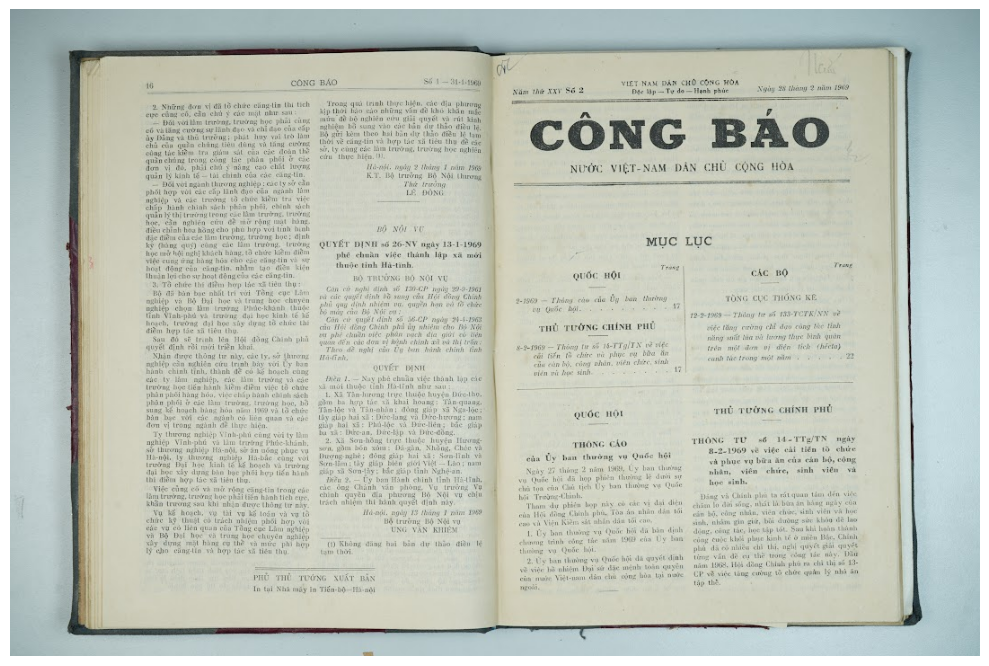

In [3]:
# Read the image
img_path = "data/image.png"
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# show image
plt.figure(figsize=(10, 8))
plt.imshow(img_rgb)
plt.axis("off")
plt.tight_layout()
plt.show()

In [11]:
res = model.predict(img_rgb)[0]                 # first (and only) image result
boxes = getattr(res, "boxes", None)
boxes


0: 864x1280 1 gutter, 34.7ms
Speed: 33.3ms preprocess, 34.7ms inference, 4.7ms postprocess per image at shape (1, 3, 864, 1280)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.5033], device='cuda:0')
data: tensor([[5.1592e+02, 3.7352e+01, 5.7127e+02, 6.9801e+02, 5.0326e-01, 0.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (720, 1080)
shape: torch.Size([1, 6])
xywh: tensor([[543.5982, 367.6828,  55.3519, 660.6625]], device='cuda:0')
xywhn: tensor([[0.5033, 0.5107, 0.0513, 0.9176]], device='cuda:0')
xyxy: tensor([[515.9222,  37.3515, 571.2742, 698.0140]], device='cuda:0')
xyxyn: tensor([[0.4777, 0.0519, 0.5290, 0.9695]], device='cuda:0')

All predicted boxes:
idx= 0  cls=      gutter  conf=0.503  xyxy=[515.9, 37.4, 571.3, 698.0]  in_center=True  dist_norm=0.007

Chosen (highest conf near center):
{'index': 0, 'cls_id': 0, 'cls_name': 'gutter', 'conf': 0.5032619833946228, 'xyxy': [515.9222412109375, 37.351539611816406, 571.274169921875, 698.0140380859375], 'center': [543.5982055664062, 367.68280029296875], 'center_dist_norm': 0.006535956170409918, 'in_center_window': True}


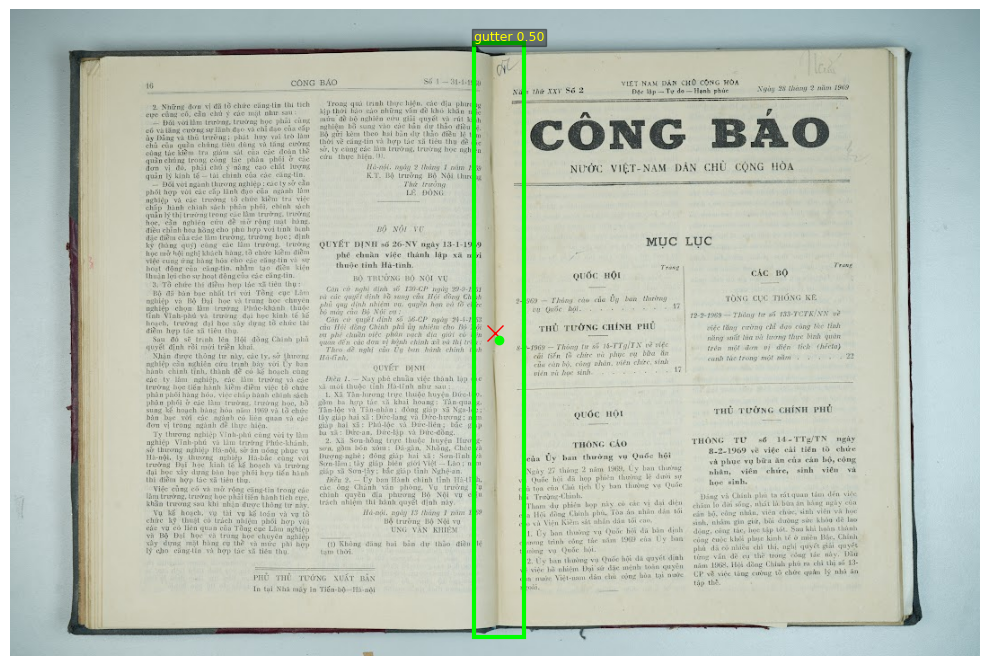

avg_x(px) = 543.60,  avg_x_norm = 0.503332


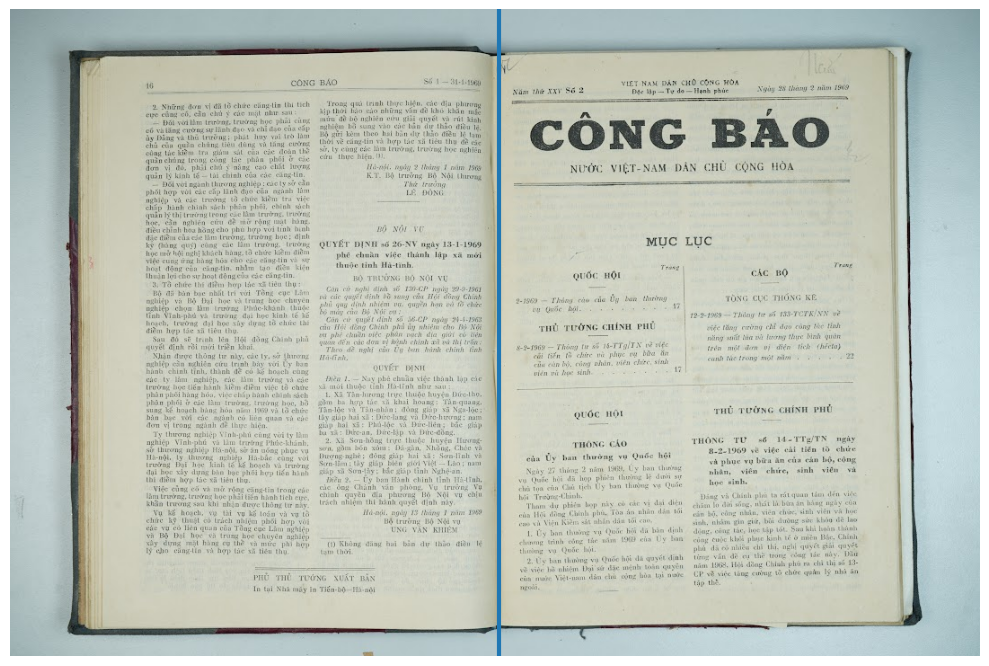

In [13]:
def pick_center_box(results, img_shape, center_frac=0.25):
    """
    Returns:
      best: dict for the chosen box (or None if no predictions)
      all_preds: list of dicts for all boxes
    center_frac: size of the 'center window' as fraction of width/height.
                 e.g., 0.25 => +/-25% W/H around image center.
    """
    H, W = img_shape[:2]
    cx, cy = W / 2.0, H / 2.0
    diag = (W**2 + H**2) ** 0.5

    boxes = getattr(results, "boxes", None)
    if boxes is None or boxes.data is None or len(boxes) == 0:
        return None, []

    xyxy = boxes.xyxy.cpu().numpy()                  # (N, 4)
    conf = boxes.conf.cpu().numpy().reshape(-1)      # (N,)
    cls_id = boxes.cls.cpu().numpy().astype(int)     # (N,)

    names = getattr(results, "names", None)
    if names is None:
        # fallback (Ultralytics usually sets results.names)
        try:
            names = results.model.names
        except Exception:
            names = {}

    preds = []
    for i, (b, c, k) in enumerate(zip(xyxy, conf, cls_id)):
        x1, y1, x2, y2 = b
        bx, by = (x1 + x2) / 2.0, (y1 + y2) / 2.0
        dist = ((bx - cx)**2 + (by - cy)**2) ** 0.5
        in_center = (abs(bx - cx) <= center_frac * W) and (abs(by - cy) <= center_frac * H)

        preds.append({
            "index": i,
            "cls_id": int(k),
            "cls_name": names.get(int(k), str(int(k))),
            "conf": float(c),
            "xyxy": [float(x1), float(y1), float(x2), float(y2)],
            "center": [float(bx), float(by)],
            "center_dist_norm": float(dist / diag),
            "in_center_window": bool(in_center),
        })

    # Prefer boxes inside the center window, pick highest confidence; tie-break by closeness to center
    center_preds = [p for p in preds if p["in_center_window"]]
    if center_preds:
        best = sorted(center_preds, key=lambda p: (-p["conf"], p["center_dist_norm"]))[0]
    else:
        # If nothing inside the window, pick the closest to center; tie-break by higher conf
        best = sorted(preds, key=lambda p: (p["center_dist_norm"], -p["conf"]))[0]

    return best, preds

best, all_preds = pick_center_box(res, img_rgb.shape, center_frac=0.25)

# Print all boxes
if not all_preds:
    print("No boxes predicted.")
else:
    print("All predicted boxes:")
    for p in all_preds:
        print(f"idx={p['index']:2d}  cls={p['cls_name']:>12}  conf={p['conf']:.3f}  "
              f"xyxy={list(map(lambda x: round(x,1), p['xyxy']))}  "
              f"in_center={p['in_center_window']}  dist_norm={p['center_dist_norm']:.3f}")

    print("\nChosen (highest conf near center):")
    print(best)

# --- visualize: all boxes (yellow), chosen box (lime), centers ---

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img_rgb)
H, W = img_rgb.shape[:2]

# draw image center
ax.plot([W/2], [H/2], marker='x', markersize=12, color='red', linewidth=2)

# draw all boxes
for p in all_preds:
    x1, y1, x2, y2 = p["xyxy"]
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=1.5, edgecolor='yellow', facecolor='none', alpha=0.7)
    ax.add_patch(rect)
    ax.text(x1, y1 - 3, f"{p['cls_name']} {p['conf']:.2f}",
            fontsize=9, color='yellow', bbox=dict(facecolor='black', alpha=0.4, pad=1.5))

# highlight chosen box
if best is not None:
    x1, y1, x2, y2 = best["xyxy"]
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=3.0, edgecolor='lime', facecolor='none')
    ax.add_patch(rect)
    bx, by = best["center"]
    ax.plot([bx], [by], marker='o', markersize=6, color='lime')

plt.axis("off")
plt.tight_layout()
plt.show()

best, all_preds = pick_center_box(res, img_rgb.shape, center_frac=0.25)

avg_x = None
if best is not None:
    x1, y1, x2, y2 = best["xyxy"]
    avg_x = (x1 + x2) / 2.0          # <- average of left/right x (pixel coordinate)
    H, W = img_rgb.shape[:2]
    avg_x_norm = avg_x / W            # optional: normalized [0,1]
    print(f"avg_x(px) = {avg_x:.2f},  avg_x_norm = {avg_x_norm:.6f}")
else:
    print("No boxes predicted; avg_x = None")

# (optional) visualize the vertical line at avg_x
if avg_x is not None:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.axvline(avg_x, linewidth=3)   # don't set colors unless you want to
    plt.axis("off")
    plt.tight_layout()
    plt.show()